In [12]:
from __future__ import print_function
from keras import backend as K
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import PIL
from PIL import Image
import pandas as pd
import random
from keras.callbacks import TensorBoard
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import Input
import os
from sklearn.metrics import precision_score, recall_score, f1_score

### Load the image data

In [2]:
data = pd.read_csv('id_genre_pairs.csv')
movie_ids = list(data['movie_id'])
data = np.array(data)

In [3]:
files = [i for i in os.listdir('Posters') if i[-3:] == 'jpg']
random.shuffle(files)

training_indices = files[:int(len(files)*0.8)]
test_indices = files[int(len(files)*0.8):]

test = []
test_labels = []
for i in test_indices:
    try:
        img = load_img('Posters/'+i)
        test.append(img_to_array(img))
        idx = int(i[:i.index(".")])
        for row in data:
            if row[0] == idx:
                test_labels.append(row[1:])
                break
    except:
        pass

In [4]:
train = []
train_labels = []
for i in training_indices:
    try:
        img = load_img('Posters/'+i)
        train.append(img_to_array(img))
        idx = int(i[:i.index(".")])
        for row in data:
            if row[0] == idx:
                train_labels.append(row[1:])
                break
    except:
        pass

### Reshape data and normalize

In [5]:
img_rows, img_cols = 32, 32
num_classes = 17

x_train = np.array(train) 
x_test = np.array(test)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [6]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

# interestingly the keras example code does not center the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (11757, 32, 32, 3)
x_test shape: (2940, 32, 32, 3)
11757 train samples
2940 test samples


### Train NN

In [13]:
batch_size=256
epochs=3

In [14]:
n_classes = 17
inp = Input(shape=input_shape)

In [9]:
# Pre-trained VGG16 NN
base_model = applications.VGG16(input_tensor=inp, weights='imagenet', include_top=False)

In [15]:
# Make the VGG portion non-trainable
for layer in base_model.layers:
    layer.trainable=False

In [16]:
histories = {}
recall = {}
precision = {}
f1 = {}
for lrate in [0.001,0.01, 0.1]:
    # Add last few layers of model for tuning
    x = base_model.output
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(n_classes, activation='sigmoid')(x)
    
    # Add top layers to pre-trained model
    model = Model(inputs=base_model.input, outputs=out)
    
    # compile model
    adam = optimizers.Adam(lr=lrate)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    tensorboard = TensorBoard(log_dir='./logs/cv/pt', histogram_freq=1, write_graph=True, write_images=False)
    
    # train the new layers
    history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=[tensorboard])
    
    histories[lrate] = history
    predictions = (model.predict(x_test)>0.1).astype(int)
    recall[lrate] = recall_score(y_test, predictions, average="micro")
    precision[lrate] = precision_score(y_test, predictions, average="micro")
    f1[lrate] = f1_score(y_test, predictions, average="micro")

Train on 11757 samples, validate on 2940 samples
INFO:tensorflow:Summary name block1_conv1/kernel:0 is illegal; using block1_conv1/kernel_0 instead.
INFO:tensorflow:Summary name block1_conv1/bias:0 is illegal; using block1_conv1/bias_0 instead.
INFO:tensorflow:Summary name block1_conv2/kernel:0 is illegal; using block1_conv2/kernel_0 instead.
INFO:tensorflow:Summary name block1_conv2/bias:0 is illegal; using block1_conv2/bias_0 instead.
INFO:tensorflow:Summary name block2_conv1/kernel:0 is illegal; using block2_conv1/kernel_0 instead.
INFO:tensorflow:Summary name block2_conv1/bias:0 is illegal; using block2_conv1/bias_0 instead.
INFO:tensorflow:Summary name block2_conv2/kernel:0 is illegal; using block2_conv2/kernel_0 instead.
INFO:tensorflow:Summary name block2_conv2/bias:0 is illegal; using block2_conv2/bias_0 instead.
INFO:tensorflow:Summary name block3_conv1/kernel:0 is illegal; using block3_conv1/kernel_0 instead.
INFO:tensorflow:Summary name block3_conv1/bias:0 is illegal; using 

### Results

In [27]:
recall_scores = [recall[key] for key in sorted(recall.keys())]
precision_scores = [precision[key] for key in sorted(precision.keys())]
f1_scores = [f1[key] for key in sorted(f1.keys())]

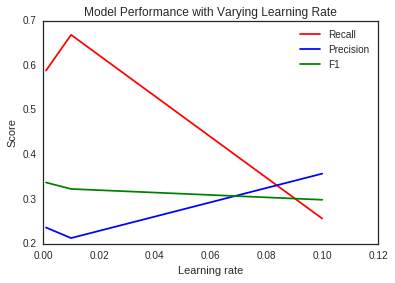

In [40]:
plt.figure()
plt.plot([0.001, 0.01, 0.1], recall_scores, c='Red', label="Recall")
plt.plot([0.001, 0.01, 0.1], precision_scores, c='Blue', label="Precision")
plt.plot([0.001, 0.01, 0.1], f1_scores, c='Green', label="F1")
plt.plot([0.001, 0.01, 0.1], )
plt.xlabel("Learning rate")
plt.ylabel("Score")
plt.title("Model Performance with Varying Learning Rate")
plt.legend()
plt.show()